# Контейнеризация приложений

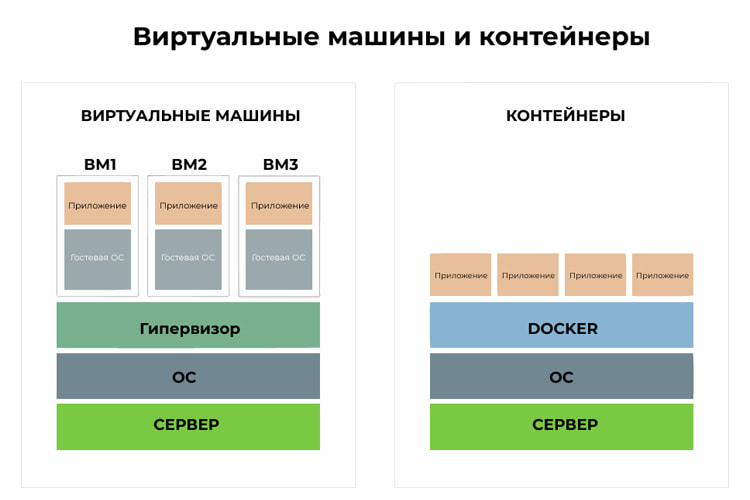

- **Виртуальная машина** — это виртуальный компьютер со всеми виртуальными устройствами и виртуальным жёстким диском, на который и устанавливается новая независимая ОС (гостевая ОС) вместе с виртуальными драйверами устройств, управлением памятью и другими компонентами. Сама виртуальная машина полностью изолирована от реального компьютера.
- **Контейнеры** и виртуальные машины решают одну задачу, но делают это по-разному. Контейнеры переиспользуют большее количество общих ресурсов хост-системы, чем VM, т.к. обеспечивает виртуализацию на уровне ОС, а не аппаратного обеспечение. Такой подход обеспечивает меньший объем занимаемого места на жёстком диске, быстрое развертывание и более простое масштабирование.

## Docker

**Docker** — это ПО для создания приложений на основе контейнеров.

- изолированная среда при запуске приложений в контейнерах
- упрощение разработки и деплоя приложений
- нет необходимости конфигурировать среду разработки, т.к. она поставляется вместе с приложением
- упрощение масштабируемости приложений с помощью оркестраторов типа k8s

### Состав докера:

1. **Образ** - read-only шаблон с инструкциями для создания контейнера. Состоит из неизменяемых слоев.
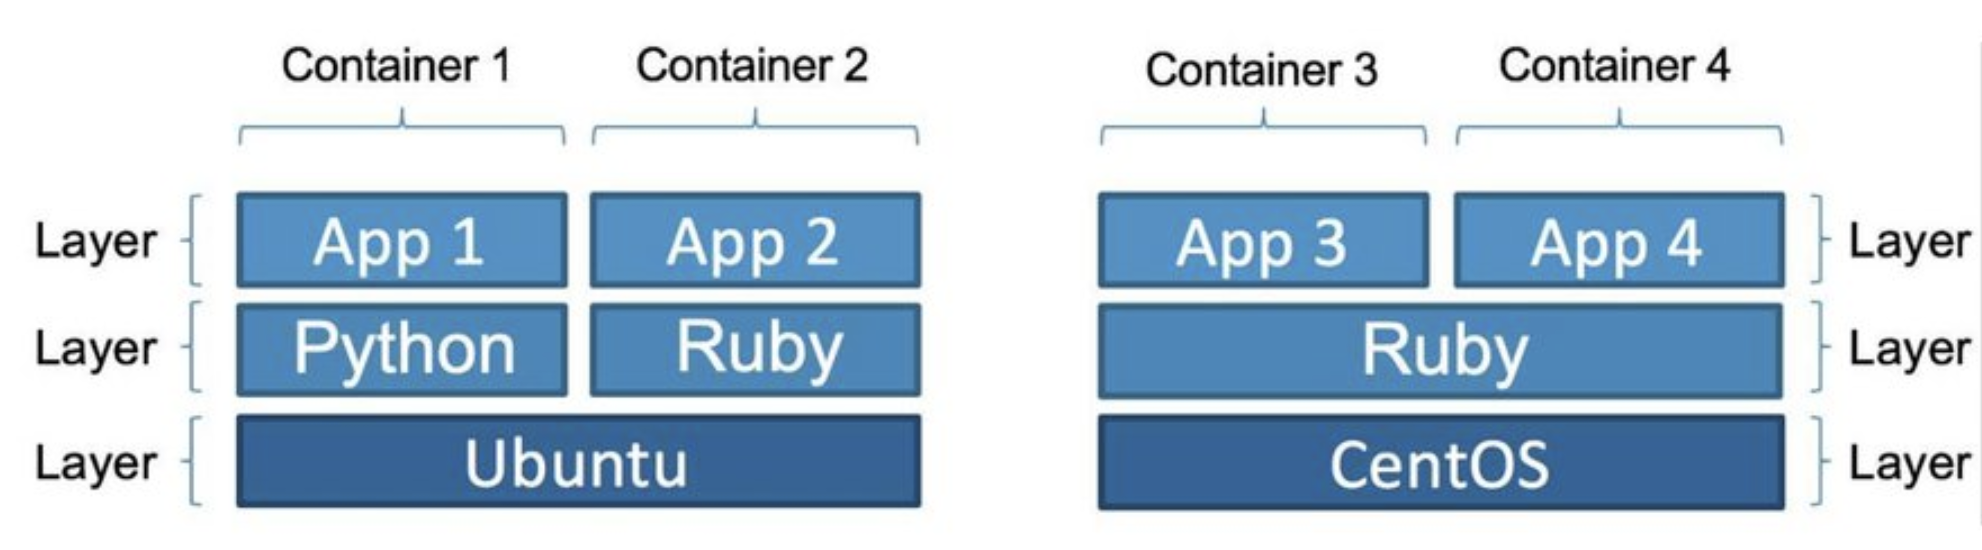

2. **Контейнер** - это экземпляр запущенного образа. Можно запускать несколько контейнеров на основе одного и того же образа. Можем провести аналогию с программированием: образ - это класс, в котором описываются характеристики среды, а контейнер - это экземпляр этого класса, который содержит информацию о более частных вещах, таких, как, например, URL папки с хранимыми файлами.

3. **Volume** - общий ресурс ОС-хоста и *контейнера* - используется для хранения больших файлов.
4. **Сеть**: несколько докер-контейнеров можно объединить в одну сеть, чтобы они могли друг с другом общаться по сетевым протоколам.

## Установка docker

Для Windows и MacOS можно установить Docker Desktop из магазинов приложений. Из терминала должны быть доступны те же команды, которые мы будем разбирать ниже для Linux. Алгоритм действий установки докера на линукс (команды нужно выполнять в терминале):

1. Скачиваем скрипт установки докера к себе на комп: `curl -fsSL https://get.docker.com -o install-docker.sh`
2. Исполняем его от имени суперпользователя: `sudo sh get-docker.sh`
3. Чтобы пользователь мог взаимодействовать с докером, нужно, чтобы он был добавлен в группу *docker*. Добавим текущего пользователя в эту группу: `sudo usermod -aG docker $USER`

Теперь можно работать с докером, например, посмотреть текущие запущенные контейнеры: `docker ps`.

## Разворачиваем готовый образ

Репозиторий образов: https://hub.docker.com/
Для примера будем разворачивать образ jupyter-notebook для Data Science специалистов (дата-сатанистов). Следующие команды нужно выполнять из терминала.

1. Скачиваем образ к себе на комп: `docker pull jupyter/datascience-notebook`
2. Теперь его можно сразу запускать! `docker run -p 8000:8888 --name=test jupyter/datascience-notebook`

В строке выше мы задали имя test нашему контейнеру, а также пробросили 8888-й порт контейнера на 8000-й порт нашей физической машины, чтобы иметь внешний доступ к веб-морде, которую выдает контейнер.

Часто мы не хотим выделять большое дисковое пространство внутри контейнера для хранения данных, а хотим разделить его с нашей основной файловой системой или другими контейнерами. Это делается с помощью Volume:

    mkdir data  # создаем новую папку в корневой файловой системе, к которой будет доступ из контейнера
    docker run -p 8000:8888 -v ~/data/:/home/jovyan/work jupyter/datascience-notebook
    
Теперь данные, собранные во время работы контейнера, не будут удалены после его удаления.

## Сборка своего образа

Если в базовом образе не хватает чего-то специфичного, нужно собрать свой образ на основе имеющихся. Сборку образа принято описывать в специальном файле Dockerfile.

1. Создадим новую папку для сборки образа: `mkdir example_image && cd example_image`
2. Создадим файл с именем Dockerfile: `touch Dockerfile`
3. Далее будем его редактировать: `nano Dockerfile`


    FROM jupyter/datascience-notebook
    WORKDIR /home/jovyan/
    COPY /home/webdev/Docker.ipynb ./
    RUN pip install django
    
Что здесь описано?

- наследуемся от базового образа jupyter/datascience-notebook
- начинаем его модифицировать: переходим в директорию /home/jovyan/ и копируем туда этот блокнот из основной файловой системы
- устанавливаем дополнительный пакет django внутрь образа


4. Из папки, в которой мы сохранили Dockerfile, собираем новый образ: `docker build -d my_awesome_image:1 .`. В этой команде мы задали нашему образу имя my_awesome_image и версию 1. Теперь по этому имени можно создавать контейнеры.

## Docker-compose

Часто нам нужно запускать одни и те же контейнеры с одними и теми же параметрами, а информации об образе из докерфайла для этого мало. Поэтому был придуман формат docker-compose, который в одном yaml-файле описывает и образ, и параметры запуска контейнеров.

Приведем файл docker-compose.yml для создания БД:

    version: "3.9"
    services:
      postgres:
        image: postgres:latest
        command: postgres -c 'max_connections=2000' -c 'idle_session_timeout=10min'
        environment:
          POSTGRES_DB: "sales"
          POSTGRES_USER: "odmen"
          POSTGRES_PASSWORD: "supersecret_password"
          PGDATA: "/var/lib/postgresql/data/pgdata"
        volumes:
          - ./db_init:/docker-entrypoint-initdb.d
          - /var/lib/postgresql/data:/var/lib/postgresql/data
        ports:
          - "8080:5432"
          
Запустить контейнер можем командой: `docker compose up -d`

## Gitlab CI

**CI** - это сборка, деплой и тестирование приложения без участия человека, т.е. автоматический запуск всех стадий проверки кода и подготовки среды исполнения при появлении новой версии кода.

Для того, чтобы прогнать тесты, собрать пакет, подготовить образ и т.д., нам нужна среда, где это будет происходить. На github.com или gitlab.com такая среда поставляется автоматически, но при использовании своего развернутого гитлаба ее нужно подготовить самостоятельно. Самый простой способ - запустить gitlab-runner на сервере.

Для этого нужно:
1. Установить gitlab-runner
2. Запустить его
3. Зарегистрировать его в репозитории
4. Прописать алгоритм CI в файле .gitlab-ci.yml

Пример .gitlab-ci.yml:

    build-job:
      stage: build
      script:
        - echo "Hello, $GITLAB_USER_LOGIN!"

    test-job1:
      stage: test
      script:
        - echo "This job tests something"

    test-job2:
      stage: test
      script:
        - echo "This job tests something, but takes more time than test-job1."
        - echo "After the echo commands complete, it runs the sleep command for 20 seconds"
        - echo "which simulates a test that runs 20 seconds longer than test-job1"
        - sleep 20

    deploy-prod:
      stage: deploy
      script:
        - echo "This job deploys something from the $CI_COMMIT_BRANCH branch."
      environment: production


https://docs.gitlab.com/ee/ci/quick_start/